## Robot-like examples - 2021 1216 CJH
#### In a nutshell:
* Make a robot
* Make a subsystem
* Make a command to interface with the subsystem
* Bind the command to a joystick 

####  Why do we do that?  (How does the robot work?)
* The robot runs a main loop 50 times per second
* We could tell it what to do every time
    * read the joystick and move
    * read the buttons and actuate elevators, shooters, etc
    * do background computation 
* But as it gets complicated we will start making mistakes and interfering with ourselves
  * You can do it, but you get a lot of nested if statemenets
  * What happens if we want to switch to a slow-movement mode with the d-pad instead of racing around with the joystick? 
* So we follow a "command-based" template that establishes a **scheduler**, which 
  * keeps track of all the actions (commands) we want to run in a queue
  * has clear rules for starting and stopping actions
  * has clear rules for precedence and graceful interrupting (like when two commands want the same subsystem) 

---
### Import the **robot** library and look at what it gives us
* below is the the essence of what happens in robot.py
* you just start an instance of CommandBasedRobot()
* except you modify the robot class' member functions to suit your robot
* because under the hood is all the functionality for running the robot's timing loop

In [ ]:
# get the CommandBasedRobot class from the pyfrc library
from commandbased import CommandBasedRobot

In [2]:
robot = CommandBasedRobot()  # make an instance of the command based robot

In [90]:
#list all of the attributes meant to be public
robot_attribs = [attrib for attrib in dir(robot) if '__' not in attrib]
_ = [print(attrib, end=', ') if (ix+1)%6!=0 else print(attrib, end='\n') for ix, attrib in enumerate(robot_attribs) ]

_loopFunc, _m_period, _simulationInit, _simulationPeriodic, addPeriodic, autonomousInit
autonomousPeriodic, commandPeriodic, disabledInit, disabledPeriodic, ds, endCompetition
getControlState, getPeriod, handleCrash, intake, isAutonomous, isAutonomousEnabled
isDisabled, isEnabled, isNewDataAvailable, isOperatorControl, isOperatorControlEnabled, isReal
isSimulation, isTest, kDefaultPeriod, logger, main, robotInit
robotPeriodic, setNetworkTablesFlushEnabled, startCompetition, teleopInit, teleopPeriodic, testInit
testPeriodic, 

#### after this you would add subsystems to the robot and redefine the autonomous, teleop and other commands

---
### Import a **subsystem**
* these are in your subsystems folder
* basically you use the Subsystem class and add member functaions and attributes
* override the ones that you need to customize
* add motors, controllers and sensors to your subsystem

In [62]:
# get the Subsystem class from the pyfrc library and the Spark motor controller
from wpilib.command import Subsystem
from wpilib import Spark


class Intake(Subsystem):
    def __init__(self, robot):
        Subsystem.__init__(self, "intake")
        self.robot = robot
        self.intake_spark = Spark(6)
        self.counter = 0
        # TODO: set a default command so we are always closing the intake?

    def initDefaultCommand(self):
        """
        When other commands aren't using the gate, keep it closed (or rely on spring)
        Let it reset every 60s - should not be a problem
        """

    def run_intake(self, power=0):
        self.intake_spark.set(power)


    def log(self):  # old style of having a subsystem periodic function; now use the periodic function
        self.counter += 1
        if self.counter % 10 == 0:
            pass
        
    def periodic(self) -> None:
        """Perform necessary periodic updates"""
        self.counter += 1
        if self.counter % 5 == 0:
            pass
            # ten per second updates
            #SmartDashboard.putNumber('IntakePower', self.intake_spark.getSpeed())

In [63]:
intake = Intake(robot=None)
intake.run_intake(0.5)

In [64]:
intake.intake_spark.getSpeed()

0.5

In [67]:
_ = [intake.log() for i in range(10)]

In [68]:
intake.counter

11

In [72]:
intake_attrib = [attrib for attrib in dir(intake) if '__' not in attrib]
_ = [print(attrib, end=', ') if (ix+1)%6!=0 else print(attrib, end='\n') for ix, attrib in enumerate(intake_attrib)]

_m_error, addChild, clearError, clearGlobalErrors, cloneError, counter
getCurrentCommand, getCurrentCommandName, getDefaultCommand, getDefaultCommandName, getError, getGlobalError
getGlobalErrors, getName, getSubsystem, initDefaultCommand, initSendable, intake_spark
log, periodic, robot, run_intake, setCurrentCommand, setDefaultCommand
setErrnoError, setError, setErrorRange, setGlobalError, setGlobalWPIError, setImaqError
setName, setSubsystem, setWPIError, statusIsFatal, 

### Now make a **command** so you can tell the intake (a subsystem) to turn on (a subsystem function)
* This is why it is called a command-based robot
* All commands look like this.  
* You inherit the class template from Command, add members and override the steps
* Need an _ init _, initialize, execute, is_finished, end, interrupted functions
* Initially you think this is a lot of work but the enforced structure keeps the robot from puking
  * You can force it to 'own' a subsystem - stops other commands running on it
  * That means you should not be able to it to stop and go at the same time
* This one is a tad complicated because we really wanted this to work on a held-button approach
  * Works fine in the workshop but much more difficult on the field
  * When the comms system drops a packet, _it sees all buttons as unpressed_ ...

In [91]:
from wpilib.command import Command
from wpilib import Timer
from wpilib import SendableBuilder

class RunIntake(Command):
    """
    This command sets the intake
    """

    def __init__(self, robot, power=0.1, button=None, end_power=0, timeout=None):
        Command.__init__(self, name='Intake')
        self.requires(robot.intake)      # I can't run this in the notebook without some trickery below
        self.robot = robot
        self.timeout = timeout
        self.button = button
        self.power = power
        self.end_power = end_power
        self.max_power = 0.8

        self.unpressed_min = 5
        self.unpressed_counter = 0


    def initialize(self):
        """Called just before this Command runs the first time."""
        self.start_time = round(Timer.getFPGATimestamp() - self.robot.enabled_time, 1)
        print("\n" + f"** Started {self.getName()} with power {self.power} at {self.start_time} s **", flush=True)

        if self.timeout is not None:
            self.setTimeout(self.timeout)
        self.unpressed_counter = 0

    def execute(self):
        """Called repeatedly when this Command is scheduled to run"""
        """        if self.button == self.robot.oi.axisButtonRT:
            self.power = self.robot.oi.stick.getRawAxis(3) * self.max_power
        elif self.button == self.robot.oi.axisButtonLT:
            self.power = -self.robot.oi.stick.getRawAxis(2) * self.max_power
        if self.robot.oi.competition_mode:
            if self.button == self.robot.oi.co_axisButtonRT:
                self.power = self.robot.oi.co_stick.getRawAxis(3) * self.max_power
            elif self.button == self.robot.oi.co_axisButtonLT:
                self.power = -self.robot.oi.co_stick.getRawAxis(2) * self.max_power
        """
        self.power = self.max_power * self.max_power  # simple constraint
        self.robot.intake.run_intake(self.power)

        # challenge: see if you can explain what this does
        if self.button:
            pressed = self.button.get()
            if not pressed:
                self.unpressed_counter += 1
            else:
                self.unpressed_counter = 0

    def isFinished(self):
        """Make this return true when this Command no longer needs to run execute()"""
        if self.button is not None:
            return self.unpressed_counter >= self.unpressed_min
        elif self.timeout is not None:
            return self.isTimedOut()
        else:
            return True


    def end(self, message='Ended'):
        """Called once after isFinished returns true"""
        print(f"** {message} {self.getName()} at {round(Timer.getFPGATimestamp() - self.robot.enabled_time, 1)} s **")
        # Note to self: do not reset self.power here!
        self.robot.intake.run_intake(self.end_power)

    def interrupted(self):
        """Called when another command which requires one or more of the same subsystems is scheduled to run."""
        self.end(message='Interrupted')



In [85]:
robot.intake = intake
intake_command = RunIntake(robot=robot)

In [89]:
# all the methods avaialble to intake_command
intake_cmd_attrib = [attrib for attrib in dir(intake_command) if '__' not in attrib]
_ = [print(attrib, end=', ') if (ix+1)%8!=0 else print(attrib, end='\n') for ix, attrib in enumerate(intake_cmd_attrib)]

_cancel, _end, _execute, _initialize, _interrupted, _m_error, assertUnlocked, button
cancel, clearError, clearGlobalErrors, clearRequirements, cloneError, doesRequire, end, end_power
execute, getError, getGlobalError, getGlobalErrors, getGroup, getID, getName, getRequirements
getSubsystem, initSendable, initialize, interrupted, isCanceled, isCompleted, isFinished, isInitialized
isInterruptible, isParented, isRunning, isTimedOut, max_power, power, requires, robot
run, setErrnoError, setError, setErrorRange, setGlobalError, setGlobalWPIError, setImaqError, setInterruptible
setName, setParent, setRunWhenDisabled, setSubsystem, setTimeout, setWPIError, start, statusIsFatal
timeSinceInitialized, timeout, unpressed_counter, unpressed_min, willRunWhenDisabled, 

### *And in the darkness, bind them.*
* Need to tell the assign button actions from the joystick to your command
* we do this in oi.py  (operator interface)

In [96]:
import wpilib
from wpilib.command import JoystickButton
class OI(object):
    """
    The operator interface of the robot.  Note we use competition_mode to determine if we will
    initialize a second joystick.  Apparently 2021 added something so we don't have to do this anymore...
    """
    def __init__(self, robot):
        self.robot = robot

        self.initialize_joystics()
        self.assign_buttons()

    def initialize_joystics(self):
        self.stick = wpilib.Joystick(0)
        self.buttonA = JoystickButton(self.stick, 1)
        self.buttonB = JoystickButton(self.stick, 2)
        
    def assign_buttons(self):
        self.buttonA.whenPressed(RunIntake(self.robot, power=0.5))  # intake forward
        self.buttonB.whenPressed(RunIntake(self.robot, power=-0.5))  # intake reverse

In [97]:
oi = OI(robot=robot)

## Note how we keep passing 'robot' to everything
* The actual robot definition should look like this - it needs subsystems and OI
* I cheated above for the sake of pedagogy

In [ ]:
class Robot(CommandBasedRobot):
    """Main robot class"""
    # class variables get defined up here
    
    def robotInit(self):
        """Robot-wide initialization code should go here"""
        super().__init__()

        self.intake = Intake(self)

        # oi MUST be created after all other subsystems since it uses them
        self.oi = OI(self)

        self.enabled_time = 0  # something is especially weird with the sim about this needing to be initialized in robotInit
        self.autonomousCommand = None  # initialize the placeholder command for autonomous

### Much more (but not today)
* Advanced telemetry (getting data from the robot)
* Odometry (tracking the robot with its orientation and wheel revolutions)
* Control algorithms (holding mechanisms at desired setpoints)
* Autonomous routines
* Advanced plotting
* Disk and network communications
* and so on ...

### What the robot directory looks like
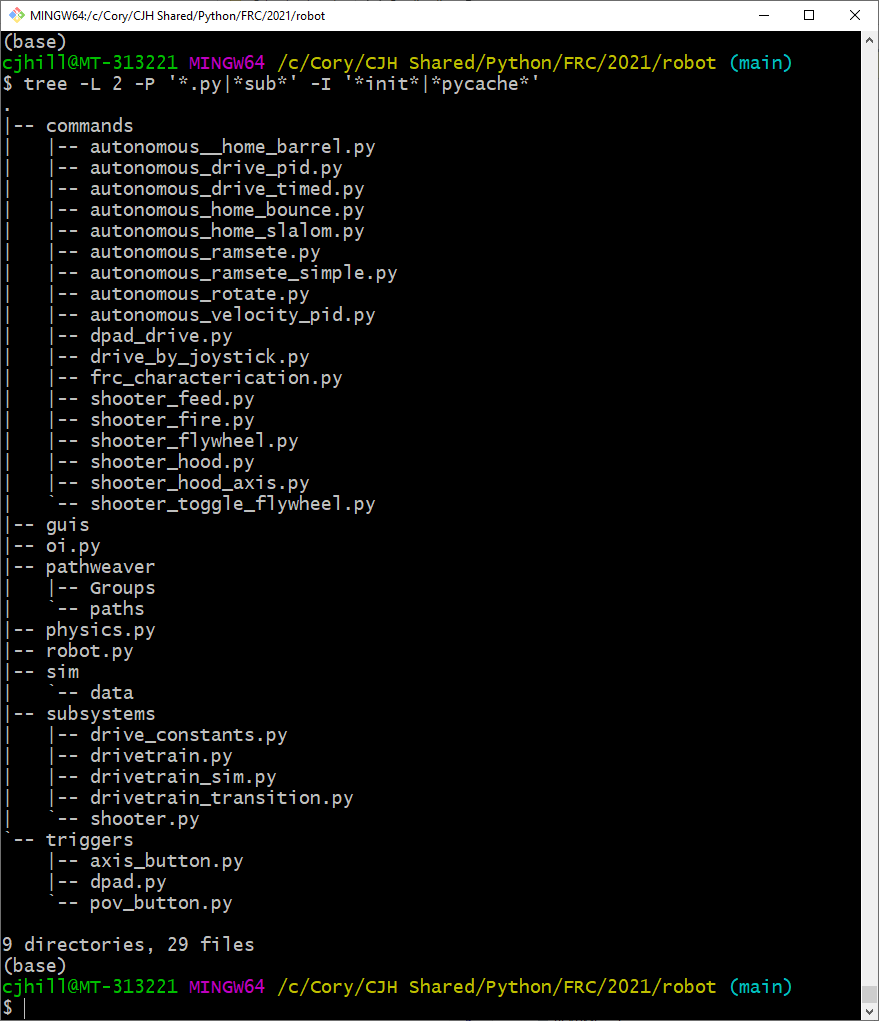